In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random as rd
import csv
import numpy as np
import math

In [4]:
# Constants
MAX = 2e9
MIN = 1e-5
NUM_DEC = 5
FACTOR = 0.9
MIN_P = 0.55
MAX_P = 0.95
SMALL = 50
MEDIUM = 100
LARGE = 200
TEST_SIZE = 10

# same as number of TA's? TODO:fix this
SMALL_H = 50
MEDIUM_H = 100
LARGE_H = 200

# maximum number of TA's / homes
SMALL_TA = 25
MEDIUM_TA = 50
LARGE_TA = 100

In [5]:
# G = nx.Graph([(1,1), (2,2), (1,2), (1,2)])
G = nx.Graph()
G.add_node(1)
G.add_node(2)
G.add_edge(1, 2)
G.add_edge(2, 2)
A = nx.adjacency_matrix(G)
print(A.todense())

[[0 1]
 [1 1]]


In [6]:
G = nx.Graph()
# H = nx.path_graph(2)
# G.add_nodes_from(H)
G = nx.petersen_graph()
# pos = nx.nx_agraph.graphviz_layout(G)
# nx.draw(G, pos=pos)
# plt.show()
# plt.subplot(121)

# nx.draw(G, with_labels=True, font_weight='bold')
# plt.subplot(122)

# nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')


[0, 1, 2]
[(0, 1), (0, 2), (1, 2)]
{'weight': 4.7}
9


/home/radar/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


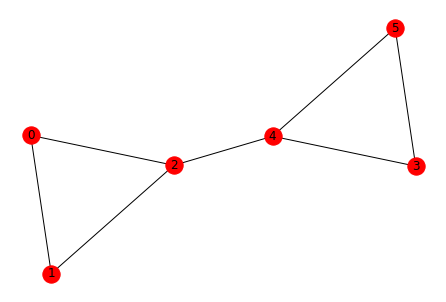

In [7]:
G1 = nx.complete_graph(3)
# plt.subplot(121)
# nx.draw(G1, node_color='blue', with_labels=True)
print(list(G1.nodes()))
print(list(G1.edges()))

G2 = nx.complete_graph(range(3,6))
# plt.subplot(122)
# nx.draw(G2, node_color='red', with_labels=True)

G3 = nx.union(G1, G2)
G3.add_edge(2, 4, weight=4.7)
print(G3[4][2])
nx.draw(G3, node_color='red', with_labels=True)
print(list(G.nodes()).pop())

In [8]:
def add_weights(g):
    w1 = rd.uniform(MIN, MAX)
    w2 = rd.uniform(MIN_P * w1, MAX_P * w1)
    w3 = rd.uniform(MIN_P * w1, MAX_P * w1)
    ws = [w1, w2, w3]
    for _, data in g.edges.items():
        data['weight'] = round(ws.pop(), NUM_DEC)
    
def connect(G, g):
    Gnodes = list(G.nodes)
    gnodes = list(g.nodes)
    G = nx.union(G, g)
    for n in gnodes:
        idx = rd.randrange(0, len(Gnodes))
        a = Gnodes.pop(idx)
        try:
            w = nx.shortest_path_length(G, source=a, target=n) * FACTOR
        except nx.NetworkXNoPath:
            ws = [i for _, _, i in g.edges.data('weight')]
            w = rd.uniform(min(ws), max(ws)) * FACTOR
        G.add_edge(a, n, weight=round(w, NUM_DEC))
    return G
        
def gen_graph(n):
    G = nx.Graph()
    while n:
        a = n.pop()
        b = n.pop()
        c = n.pop()
        nodes = [a, b, c]
        g = nx.complete_graph(nodes)
        add_weights(g)
        if len(G.nodes) == 0:
            G = g
        else:
            G = connect(G, g)
    return G

[['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 4.5, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 779447038.68203, 945061149.86734, 'x'], ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 4.5, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 779447038.68203, 945061149.86734, 'x'], ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 4.5, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 779447038.68203, 945061149.86734, 'x'], ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 4.5, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 779447038.68203, 945061149.86734, 'x'], ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 4.5, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 779447038.68203, 945061149.86734, 'x'], ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 4.5, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 779447038.68203, 945061149.86734, 'x'], ['x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 4.5, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 779447038.68203, 

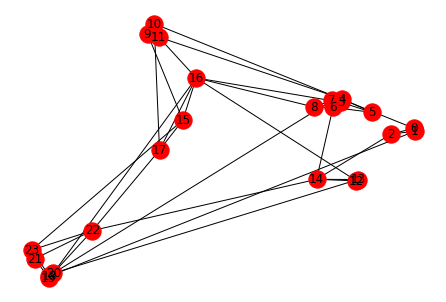

In [9]:
G = gen_graph(list(range(24)))
try:
    nx.shortest_path_length(G, source=2, target=3)
except nx.NetworkXNoPath:
    print("No path")
# for e in G.edges.items():
#     print(e)
nx.draw(G, node_color='red', with_labels=True)
A = nx.adjacency_matrix(G).toarray()
B = [[None] * len(A[0])] * len(A)
for i in range(len(A)):
    for j in range(len(A[0])):
        if A[i][j] == 0.0:
            B[i][j] = 'x'
        else:
            B[i][j] = A[i][j]
print(B)

In [10]:
def write_to_file(file, string, append=False):
    if append:
        mode = 'a'
    else:
        mode = 'w'
    with open(file, mode) as f:
        f.write(string)


def write_data_to_file(file, data, separator, append=False):
    if append:
        mode = 'a'
    else:
        mode = 'w'
    with open(file, mode) as f:
        for item in data:
            f.write(f'{item}{separator}')

In [11]:
f = open('world-cities.csv')
csv_f = csv.reader(f)
world_cities = []
for r in csv_f:
    name = r[0]
    if name.isalpha() and name != 'name':
        world_cities.append(name)
city_num = len(world_cities)
# print(world_cities)
small_list = []
medium_list = []
large_list = []
for i in range(SMALL):
    idx = rd.randrange(0, city_num)
    small_list.append(world_cities[idx])
for i in range(MEDIUM):
    idx = rd.randrange(0, city_num)
    medium_list.append(world_cities[idx])
for i in range(LARGE):
    idx = rd.randrange(0, city_num)
    large_list.append(world_cities[idx])

In [12]:
input_file = "7\n4\nSoda"
write_to_file("input.txt", input_file)

# Method 2: Complete Graph with Random Weights Adjusted

Generate a complete graph with random weights associated each edge. Use floyd_warshall to produce the 
all-pairs shortest path distances. For each edge, set the length of the edge to be the length of the shortest distance between those two vertices.

Drawbacks: After adjusting the weights, some points become lying along the way between two points as their middle points. It also requires more time to generate a valid graph.

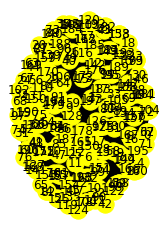

In [13]:
# Generate 
G_final = nx.complete_graph(LARGE)
plt.subplot(121)
nx.draw(G_final, node_color='yellow', with_labels=True)

# print(list(G1.nodes()))
# print(list(G1.edges()))

In [34]:
def print_edge_weights(g, n=5):
    for edge, data in g.edges.items():
        if n <= 0:
            break
        n-=1
        print(edge, data)  

In [29]:
def add_weights2(g, lower, upper):
    """Update the weight of each edge to be a random weight within the bounds."""
    for edge, data in g.edges.items():
        w = rd.uniform(lower, upper)
        data['weight'] = round(w, NUM_DEC)
#         print(edge, data)        

In [16]:
# dict1 = nx.floyd_warshall(G_final, weight='weight')
# plt.subplot(121)
# nx.draw(G_final, node_color='yellow', with_labels=True)
# print(list(G_final.nodes()))
# print(list(G_final.edges().items()))
# dict1 = nx.all_pairs_shortest_path_length(G_final)

In [17]:
def print_shortest_pair_distance(g):
    rs = nx.floyd_warshall(g)
    for i in rs:
        for j in rs[i]:
            print ("%d\t%d\t%f" % (i, j, rs[i][j]))

In [18]:
def fix_triangle_inequalities(g):
    done = False
    count = 0
    num_fixes = 0
    while not done:
        done = True
        rs = nx.floyd_warshall(g, weight='weight')
        print("iteration ", count)
        for edge, data in g.edges.items():
            if data['weight'] > rs[edge[0]][edge[1]]:
#                 print('change ' + str(edge) + " " + str(data['weight']) + " to " + str(rs[edge[0]][edge[1]]))
                data['weight'] = rs[edge[0]][edge[1]]
                done = False
                num_fixes += 1
#                 break # with break will lead to less fixes but takes more time to update
        count += 1
    print("total fixes: ", num_fixes)

Generate random weight for each edge.

In [35]:
# G_final[2][3]['weight'] = 78.73409
add_weights2(G_final, MIN, MAX)
print_edge_weights(G_final)  

(0, 1) {'weight': 1040109694.77165}
(0, 2) {'weight': 321224077.06374}
(0, 3) {'weight': 1910378435.15605}
(0, 4) {'weight': 613168914.56089}
(0, 5) {'weight': 1040413195.77911}


Fix the weight to satisfy the trangle inequalities.

In [36]:
fix_triangle_inequalities(G_final)
print_edge_weights(G_final)  

iteration  0
iteration  1
total fixes:  32
(0, 1) {'weight': 766086069.51615}
(0, 2) {'weight': 321224077.06374}
(0, 3) {'weight': 1063091243.23111}
(0, 4) {'weight': 613168914.56089}
(0, 5) {'weight': 846503511.77863}


# Method 3: Generate Random Coordinates Within Bounds

Genearte random points with coordinates (x, y), where 0 < x < 1billion and 0 < y < 1 billion st the maximum possible weight is sqrt(1billion^2 + 1billion^2). They just calcuate the edge weight for each edge between vertices

In [135]:
def generate_random_coordinates(num_verticies, included_rects):
    """ generate a list of random coordinates which are in the included rects.
    included_rect = [[x_left, x_right, y_bot, y_top], ...]"""
    print("included_rects:", included_rects)
    coords = []
    minX = float('inf')
    minY = float('inf')
    maxX = -float('inf')
    maxY = -float('inf')
    for i in range(num_verticies):
        rect = rd.choice(included_rects)
        
        x = round(rd.uniform(rect[0], rect[1]), NUM_DEC)
        y = round(rd.uniform(rect[2], rect[3]), NUM_DEC)
        
        coords.append((x, y))
        if x < minX:
            minX = x
        if y < minY:
            minY = y
        if x > maxX:
            maxX = x
        if y > maxY:
            maxY = y
    print("minX: ", minX)
    print("minY: ", minY)
    print("maxX: ", maxX)
    print("maxY: ", maxY)
#     print(coords)
    return coords

def calculate_dist(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

In [136]:
# Plot coordinates in scatter plot
def plot_coordinates(data):
    """data: list of tuples (x, y)"""
    data = np.array(data)
    x, y = data.T
    plt.scatter(x,y)
    plt.show()

included_rects: [[0, 1000000000.0, 0, 1000000000.0], [1000000000.0, 2000000000.0, 1000000000.0, 2000000000.0]]
minX:  2389608.15705
minY:  12811397.05243
maxX:  1983386291.40668
maxY:  1998534466.52736


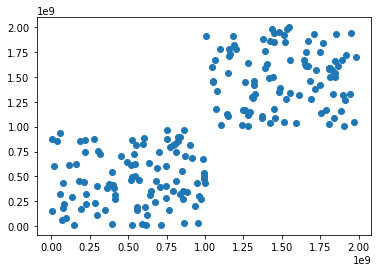

In [137]:
# test included_rect
coords = generate_random_coordinates(LARGE, [[0, .5*MAX, 0, .5*MAX], [.5*MAX, MAX, .5*MAX, MAX]])
plot_coordinates(coords)
# print(coords)

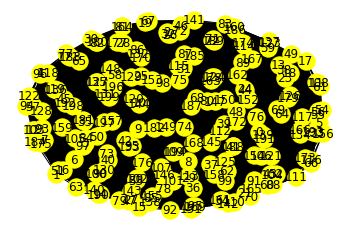

In [138]:
# Generate 
G_final = nx.complete_graph(LARGE)
plt.subplot()
nx.draw(G_final, node_color='yellow', with_labels=True)

In [139]:
def add_weights3(g, coords, num_print_msg=5):
    """Update the weight of each edge to be the distance between their location."""
    for edge, data in g.edges.items():
        data['weight'] = round(calculate_dist(coords[edge[0]], coords[edge[1]]), NUM_DEC)
        if num_print_msg > 0:
            print(str(edge) + "weight: " + str(data['weight']))
        num_print_msg -= 1

In [140]:
add_weights3(G_final, coords)

(0, 1)weight: 283893232.75572
(0, 2)weight: 2260846122.22118
(0, 3)weight: 1568229403.61583
(0, 4)weight: 2339603129.34819
(0, 5)weight: 204571791.14972


iteration  0
total fixes:  0


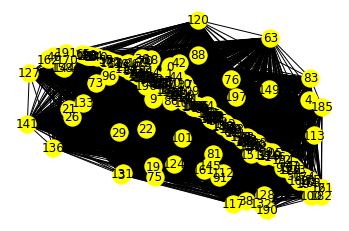

In [141]:
fix_triangle_inequalities(G_final)
plt.subplot()
nx.draw(G_final, node_color='yellow', with_labels=True)

## Save and Load a Graph Object from File Using Pickle

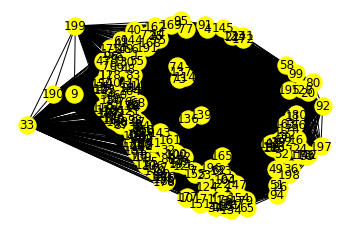

In [133]:
import pickle
# save a graph obj
filename = "G_final_1.p"

plt.subplot()
nx.draw(G_final, node_color='yellow', with_labels=True)

pickle.dump(G_final, open(filename, "wb"))

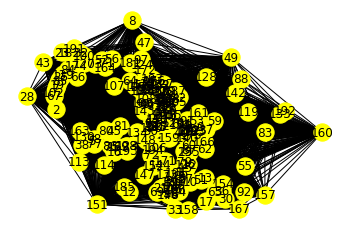

In [134]:
import pickle
G_final_copy = pickle.load( open(filename, "rb"))

plt.subplot()
nx.draw(G_final_copy, node_color='yellow', with_labels=True)

# Metric TSP Solver

## Method 1: A polynomial-time Algo with cost <= 2*optimal

1. Take the MST of G.
2. Do a DPS on MST to get PT(pseudotour).
3. Go from PT to T* (Take each vertex only the first time it appears in PT)

[(0, 1, {'weight': 9.66641}), (0, 2, {'weight': 8.95962}), (0, 3, {'weight': 9.68841}), (0, 4, {'weight': 2.29808}), (0, 5, {'weight': 5.60092}), (0, 6, {'weight': 6.86277}), (0, 7, {'weight': 7.13293}), (0, 8, {'weight': 4.24615}), (0, 9, {'weight': 6.6353}), (1, 2, {'weight': 4.36598}), (1, 3, {'weight': 6.06152}), (1, 4, {'weight': 6.80102}), (1, 5, {'weight': 7.59561}), (1, 6, {'weight': 7.74273}), (1, 7, {'weight': 4.83878}), (1, 8, {'weight': 6.19748}), (1, 9, {'weight': 1.9282}), (2, 3, {'weight': 4.41941}), (2, 4, {'weight': 3.66169}), (2, 5, {'weight': 9.01217}), (2, 6, {'weight': 3.34736}), (2, 7, {'weight': 9.73128}), (2, 8, {'weight': 4.28154}), (2, 9, {'weight': 7.44158}), (3, 4, {'weight': 7.27963}), (3, 5, {'weight': 6.85582}), (3, 6, {'weight': 2.0336}), (3, 7, {'weight': 3.78951}), (3, 8, {'weight': 1.2802}), (3, 9, {'weight': 8.39185}), (4, 5, {'weight': 5.39646}), (4, 6, {'weight': 2.53549}), (4, 7, {'weight': 3.62488}), (4, 8, {'weight': 2.85058}), (4, 9, {'weight':

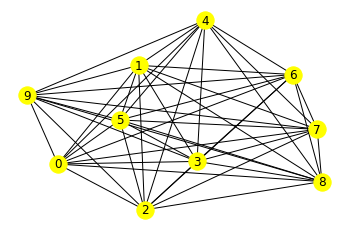

In [150]:
G1 = nx.complete_graph(10)
add_weights2(G1, 1, 10)
print(list(G1.edges().data()))
plt.subplot()
nx.draw(G1, node_color='yellow', with_labels=True)

[(0, 1, {'weight': 9.66641}), (0, 2, {'weight': 8.95962}), (0, 3, {'weight': 9.68841}), (0, 4, {'weight': 2.29808}), (1, 2, {'weight': 4.36598}), (1, 3, {'weight': 6.06152}), (1, 4, {'weight': 6.80102}), (2, 3, {'weight': 4.41941}), (2, 4, {'weight': 3.66169}), (3, 4, {'weight': 7.27963})]


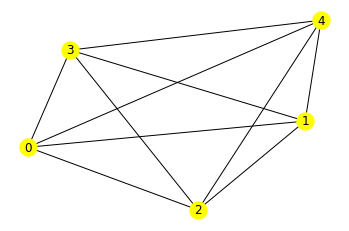

In [152]:
ta_homes = [0,1,2,3,4]
G1_sub = G1.subgraph(ta_homes)
print(list(G1_sub.edges().data()))
plt.subplot()
nx.draw(G1_sub, node_color='yellow', with_labels=True)

[(0, 4, {'weight': 2.29808}), (1, 2, {'weight': 4.36598}), (2, 4, {'weight': 3.66169}), (2, 3, {'weight': 4.41941})]


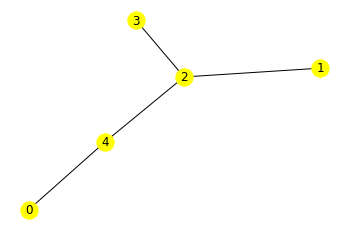

In [161]:
PT = nx.minimum_spanning_tree(G1_sub)
# print(sorted(PT.edges(data=True)))
print(PT.edges(data=True))

plt.subplot()
nx.draw(PT, node_color='yellow', with_labels=True)

In [163]:
list(nx.dfs_edges(PT, source=0))


[(0, 4), (4, 2), (2, 1), (2, 3)]